# NLP Project
Quora Question Pairs


Input the dataset:
There have two dataset train data and test data.

In [6]:
import numpy as np 
import pandas as pd 


train_df = pd.read_csv("train.csv.zip")
train_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [7]:
test_df = pd.read_csv("test2.csv.zip")
test_df.head()

test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?

Improt all the libaries that we will need in this project

In [8]:
import torch
import torch.nn as nn

# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

# !pip install -c conda-forge transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
transformers.logging.set_verbosity_error()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 1024

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/workspaces/NLE_project/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


# Data Analysis

## Sentence length setect
Do some analsis and remove some of the missing values, because the data is text. Then check the length of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: ylabel='Count'>

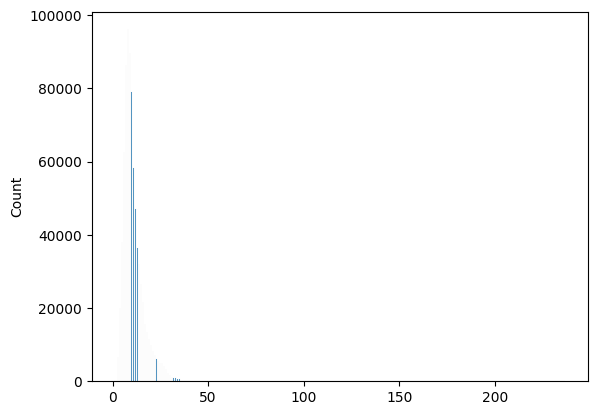

In [9]:
train_df.info()

train_df.dropna(inplace=True)
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())
sns.histplot(train_sentences_lens)


From the graph you can see that most the data are all under 50 words in every sentence.

So we can set 50 as the maximun lenth of the sentence.

In [10]:
MaximunLen = 50

## Number of the sentences
Let see how many different questions are in the data

In [11]:
qids = pd.Series(list(train_df['question1']) + list(train_df['question2']))

print ('Unique Questions number: {}\n'.format(len(np.unique(qids))))


Unique Questions number: 537359



## Analysis the duplicate and similar
Let see the percentage of duplicate and similar in the train data by analysis the duplicate in the train data.

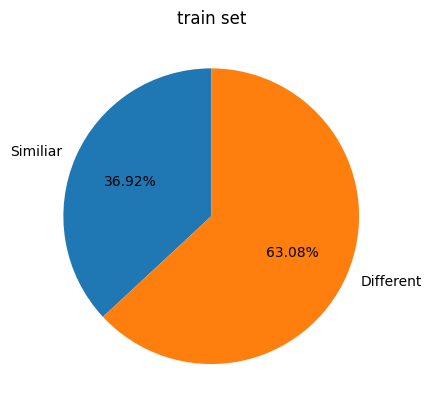

In [12]:
def pie_chart(similar_questions_num, different_questions_num, graph_title):
    labels = 'Similiar', 'Different'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(graph_title)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

    plt.show()

similar_samples_num = sum(train_df['is_duplicate'].values)
pie_chart(similar_samples_num, len(train_df['is_duplicate']) - similar_samples_num, 'train set')

## Same sentence detect
Let see if there's any paired quesions that are exacte the same.

In [13]:
duplicate_rows = train_df[train_df.duplicated(['qid1','qid2'])]
print ("Number of duplicate questions : ", len(duplicate_rows))

Number of duplicate questions :  0


## Shared words detect
Let analysis if there's shared words in both question1 and question2.

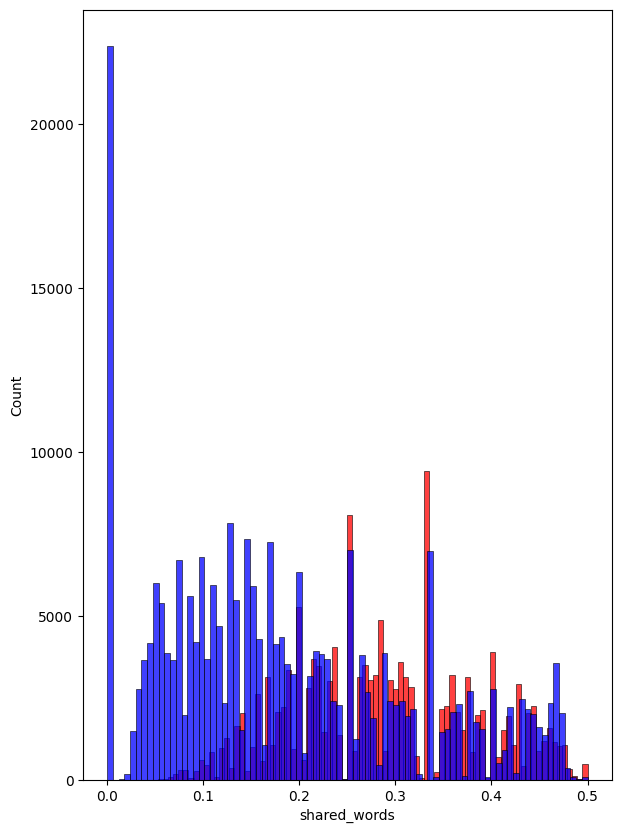

In [18]:
def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(q1_word_set & q2_word_set) / (len(q1_word_set) + len(q2_word_set))    

train_df['shared_words'] = train_df.apply(shared_words, axis=1)
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.histplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.histplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'blue' )


plt.show()

It seems that both question1 and question2 have shared words in the questions.